In [1]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# System libraries
from pathlib import Path
import os.path

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:


# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools



In [3]:
!pip install split-folders
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 12.0 MB/s eta 0:00:0000:0100:01


In [4]:
path = '/kaggle/input/plant-disease-classification-merged-dataset'

In [5]:
lst = os.listdir(path)
lst.sort()
lst

['Apple__black_rot',
 'Apple__healthy',
 'Apple__rust',
 'Apple__scab',
 'Cassava__bacterial_blight',
 'Cassava__brown_streak_disease',
 'Cassava__green_mottle',
 'Cassava__healthy',
 'Cassava__mosaic_disease',
 'Cherry__healthy',
 'Cherry__powdery_mildew',
 'Chili__healthy',
 'Chili__leaf curl',
 'Chili__leaf spot',
 'Chili__whitefly',
 'Chili__yellowish',
 'Coffee__cercospora_leaf_spot',
 'Coffee__healthy',
 'Coffee__red_spider_mite',
 'Coffee__rust',
 'Corn__common_rust',
 'Corn__gray_leaf_spot',
 'Corn__healthy',
 'Corn__northern_leaf_blight',
 'Cucumber__diseased',
 'Cucumber__healthy',
 'Gauva__diseased',
 'Gauva__healthy',
 'Grape__black_measles',
 'Grape__black_rot',
 'Grape__healthy',
 'Grape__leaf_blight_(isariopsis_leaf_spot)',
 'Jamun__diseased',
 'Jamun__healthy',
 'Lemon__diseased',
 'Lemon__healthy',
 'Mango__diseased',
 'Mango__healthy',
 'Peach__bacterial_spot',
 'Peach__healthy',
 'Pepper_bell__bacterial_spot',
 'Pepper_bell__healthy',
 'Pomegranate__diseased',
 'Pome

In [7]:
usedClass = [
 'Tomato__bacterial_spot',
 'Tomato__early_blight',
 'Tomato__healthy',
 'Tomato__late_blight',
 'Tomato__leaf_mold',
 'Tomato__mosaic_virus',
 'Tomato__septoria_leaf_spot',
 'Tomato__spider_mites_(two_spotted_spider_mite)',
 'Tomato__target_spot',
 'Tomato__yellow_leaf_curl_virus'
]

In [8]:
image_dir = Path(path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.PNG')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [9]:
labels_to_filter = usedClass
image_df = image_df[image_df['Label'].isin(labels_to_filter)]

In [10]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [12]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 10288 validated image filenames belonging to 10 classes.
Found 2572 validated image filenames belonging to 10 classes.
Found 3216 validated image filenames belonging to 10 classes.


In [13]:
class_indices = train_images.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)
class_count = len(class_names)

{'Tomato__bacterial_spot': 0, 'Tomato__early_blight': 1, 'Tomato__healthy': 2, 'Tomato__late_blight': 3, 'Tomato__leaf_mold': 4, 'Tomato__mosaic_virus': 5, 'Tomato__septoria_leaf_spot': 6, 'Tomato__spider_mites_(two_spotted_spider_mite)': 7, 'Tomato__target_spot': 8, 'Tomato__yellow_leaf_curl_virus': 9}
['Tomato__bacterial_spot', 'Tomato__early_blight', 'Tomato__healthy', 'Tomato__late_blight', 'Tomato__leaf_mold', 'Tomato__mosaic_virus', 'Tomato__septoria_leaf_spot', 'Tomato__spider_mites_(two_spotted_spider_mite)', 'Tomato__target_spot', 'Tomato__yellow_leaf_curl_virus']


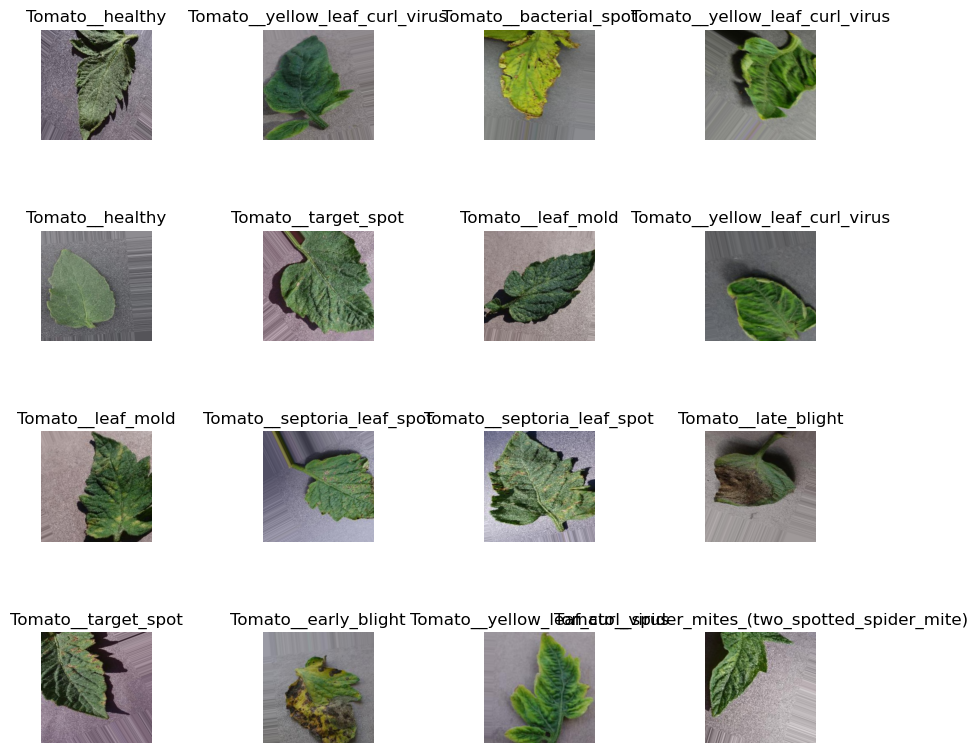

In [14]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images2, train_labels = next(train_images)
display_images(train_images2, train_labels, train_images.class_indices)
plt.show()

In [15]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, total_epochs, ask_epoch):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.total_epochs = total_epochs
        self.ask = True
        self.lowest_val_loss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch = 1

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.total_epochs:
            print('ask_epoch >= total_epochs, will train for', self.total_epochs, 'epochs', flush=True)
            self.ask = False
        if self.total_epochs == 1:
            self.ask = False
        else:
            print('Training will proceed until epoch', self.ask_epoch, 'then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        print('Loading model with weights from epoch', self.best_epoch)
        self.model.set_weights(self.best_weights)
        training_duration = time.time() - self.start_time
        hours = training_duration // 3600
        minutes = (training_duration - (hours * 3600)) // 60
        seconds = training_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg, flush=True)

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss < self.lowest_val_loss:
            self.lowest_val_loss = val_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\nValidation loss of {val_loss:7.4f} is below the lowest loss, saving weights from epoch {str(epoch + 1):3s} as the best weights')
        else:
            print(f'\nValidation loss of {val_loss:7.4f} is above the lowest loss of {self.lowest_val_loss:7.4f}, keeping weights from epoch {str(self.best_epoch)} as the best weights')

        if self.ask:
            if epoch + 1 == self.ask_epoch:
                print('\nDo you want to continue training (Y/N)?')
                ans = input()

                if ans.lower() == 'n':
                    print('Training halted on epoch', epoch + 1, 'due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += 1

In [20]:
tf.keras.backend.clear_session()

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

image_shape = (224, 224, 3)
model_name = 'MobileNet'
base_model = MobileNet(
    include_top=False,
    input_shape=image_shape,
    pooling=None,  # Remove the pooling parameter
    weights='imagenet',

)
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 60

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.3)(x)

output = Dense(class_count, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_epochs = 100
ask_epoch = 40
ask_callback = LR_ASK(model, total_epochs, ask_epoch)
rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, verbose=1)
callbacks = [rlronp_callback, ask_callback, earlystop_callback]
#del model

Number of layers in the base model:  86


In [21]:
training_history = model.fit(train_images,
                             epochs=total_epochs,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=val_images,
                             validation_steps=len(val_images),
                             initial_epoch=0)

Training will proceed until epoch 40 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/100
322/322 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.8240
Validation loss of  0.4803 is below the lowest loss, saving weights from epoch 1   as the best weights
322/322 [==============================] - 192s 579ms/step - loss: 0.5425 - accuracy: 0.8240 - val_loss: 0.4803 - val_accuracy: 0.8503 - lr: 0.0010
Epoch 2/100
322/322 [==============================] - ETA: 0s - loss: 0.2665 - accuracy: 0.9122
Validation loss of  1.0450 is above the lowest loss of  0.4803, keeping weights from epoch 1 as the best weights
322/322 [==============================] - 157s 487ms/step - loss: 0.2665 - accuracy: 0.9122 - val_loss: 1.0450 - val_accuracy: 0.7504 - lr: 0.0010
Epoch 3/100
322/322 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9317
Validation loss of  0.1870 is below t

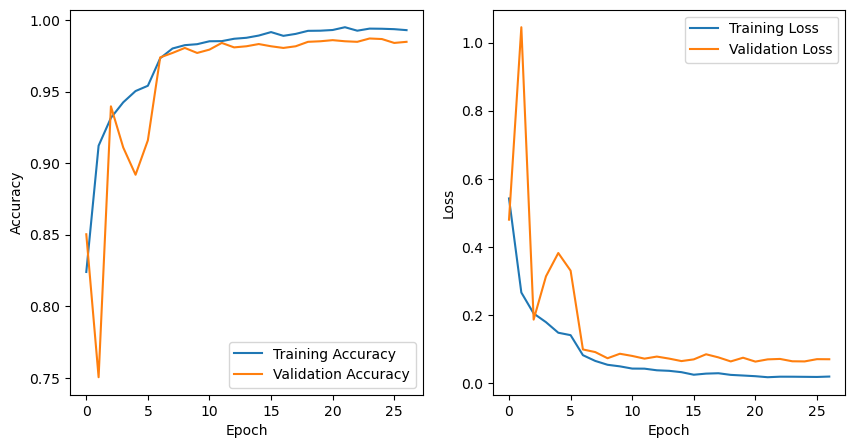

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
score = model.evaluate(test_images, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

101/101 [==============================] - 24s 237ms/step - loss: 0.0612 - accuracy: 0.9851
Test loss: 0.06121380999684334 / Test accuracy: 0.9850746393203735


In [25]:
model.save("Tomat-final.h5")